# **Book [Temp]**
> Right now the loaded model seems to be off. The outputs are not as expected. 

> It looks like the model pretrained weights are not loaded correctly.

In [58]:
import torch
import torch.nn as nn

#####################################
# Chapter 3
#####################################
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


#####################################
# Chapter 4
#####################################
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [59]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [60]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [61]:
# Loading PreTrained GPT2 124M Model Weights

import os
import tensorflow as tf
import json
import numpy as np

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


model_dir = '../../ch05/00_ME-Experimenting/gpt2/124M/'
tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

print(settings)
print(params.keys()) # Model parameters loaded successfully!

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [62]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    


load_weights_into_gpt(gpt, params)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpt.to(device);

In [63]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [64]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [65]:
for i in range(10):
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
        max_new_tokens=25,
        context_size=NEW_CONFIG["context_length"],
        top_k=50,
        temperature=1.5
    )
    print(token_ids_to_text(token_ids, tokenizer).replace('\n', '🦁'))

Every effort moves you along at a rate that moves your limbs down a step, increasing the chances that you fall. It creates an additional increase of
Every effort moves you backwards through an era where everything has changed...I mean the music stopped moving over me (Laughs), but all it did was
Every effort moves you forward but each one comes with risks and you only need good, healthy support of your brain to make you through tough times.
Every effort moves you more quickly through this process…when all else fails…it all slows down considerably🦁🦁5. Don't lose time trying
Every effort moves you back. After all, your entire mission was about to pass away... but you're fighting for it!" "Aha!
Every effort moves you along with it."🦁🦁Advertisement🦁🦁Falling victim by 20 (and a full 16 more in 2016, after an
Every effort moves you backwards. Even if it doesn't affect your mind or experience then it does change them in terms of yourself and your sense of
Every effort moves you through every 

# **Prev Chapter STUFF ❌**
| 📌 Not sure what but I'm `doing something wrong`, due to which correct `OpenAI` Pretrained weights are not loaded properly. |
| --- |


In [1]:
# Loading PreTrained GPT2 124M Model Weights

import os
import tensorflow as tf
import json
import numpy as np

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


model_dir = '../../ch05/00_ME-Experimenting/gpt2/124M/'
tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

print(settings)
print(params.keys()) # Model parameters loaded successfully!

e:\$LLMS\LLMs-from-scratch\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [2]:
# GPT Model
import torch
import torch.nn as nn

# (OLDER) GPT-2 small (124M) config
GPT_CONFIG_124M = { 
    "vocab_size": 50257, 
    "context_length": 256, #1024, 
    "emb_dim": 768, 
    "n_heads": 12, 
    "n_layers": 4, #12,  # Transformer-Block-Layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5
    
    def forward(self, x: torch.Tensor):
        '''x: 3D Tensor'''
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False) # unbiased=False => Division by `n`, rather than `n-1`
        std = x.std(-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return (x_norm * self.scale + self.shift)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            GELU(),
            nn.Linear( 4 * config['emb_dim'], config['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return (0.5 * x * (1 + torch.tanh(
            (torch.sqrt(torch.tensor(2/torch.pi))) + (x + 0.044715 * torch.pow(x, 3))
        )))

class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, n_heads, context_length, dropout=0.5, qkv_bias=False):
        super().__init__()
        assert (d_out % n_heads == 0)

        self.d_in = d_in
        self.d_out = d_out
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.d_head = (d_out // n_heads)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', torch.ones(context_length, context_length).triu(1).bool())
    
    def forward(self, x):
        '''x: 3D. x => (batch_size, num_tokens, token_embed)'''
        b, n_tokens, token_embed = x.shape
        assert self.d_in == token_embed
        
        Q = self.W_q(x) # (b, n_tokens, d_out)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(b, n_tokens, self.n_heads, self.d_head) # (b, n_tokens, n_heads, d_head)
        K = K.view(b, n_tokens, self.n_heads, self.d_head) 
        V = V.view(b, n_tokens, self.n_heads, self.d_head) 

        Q = Q.transpose(1, 2) # (b, n_heads, n_tokens, d_head)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / self.d_head**0.5 #K.shape[-1]**0.5
        attn_scores = attn_scores.masked_fill(self.mask[: n_tokens, : n_tokens], -torch.inf)
        attn_weights = attn_scores.softmax(-1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ V
        context_vectors = context_vectors.transpose(1, 2)
        context_vectors = context_vectors.contiguous().view(b, n_tokens, self.d_out)
        return self.out_proj(context_vectors)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiheadAttention(
            d_in=cfg['emb_dim'],    # 768
            d_out=cfg['emb_dim'],   # 768
            n_heads=cfg['n_heads'], # 12
            context_length=cfg['context_length'], # 1024
            dropout=cfg['drop_rate'], # 0.1
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm_1 = LayerNorm(cfg['emb_dim'])
        self.norm_2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        # Part 1:
        shortcut = x
        x = self.norm_1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut

        # Part 2:
        shortcut = x
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.pos_emb = nn.Embedding(config['context_length'], config['emb_dim'])
        self.drop_emb = nn.Dropout(config['drop_rate'])
        self.transf_layers = nn.Sequential(*[TransformerBlock(config) for _ in range(config['n_layers'])])
        self.final_norm = LayerNorm(config['emb_dim'])
        self.out_head = nn.Linear(config['emb_dim'], config['vocab_size'], bias=False)
    
    def forward(self, x, show_info=False):
        '''x: 2D Matrix'''
        batch_size, seq_len = x.shape 
        tok_emb = self.tok_emb(x) 
        pos_emb = self.pos_emb(
            torch.arange(seq_len).to(x.device)  # Ensure pos indices are on the same device as x
        )
        x = tok_emb + pos_emb
        if show_info:
            print(f'Token-Embed(shape): {tok_emb.shape}')
            print(f'POS-Embed(shape): {pos_emb.shape}')
            print(f'i/p Before TransfBlocks(shape): {x.shape}')
        x = self.drop_emb(x)
        x = self.transf_layers(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
# GPT2 Model Configurations
model_configs = { 
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12}, 
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16}, 
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20}, 
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# GPT2 124M Base Configuration:
MODEL_CONFIG = {
    'vocab_size': 50257, 
    'context_length': 256, 
    'emb_dim': 768, 
    'n_heads': 12, 
    'n_layers': 12, 
    'drop_rate': 0.1, 
    'qkv_bias': True, 
}

MODEL_CONFIG.update({
    'context_length': settings['n_ctx'],
    'emb_dim': settings['n_embd'],
})

gpt = GPTModel(MODEL_CONFIG) # Uninitialized weights
gpt.eval();


In [ ]:
# Loading pretrained weights from TensorFlow checkpoint 
import numpy as np

def assignParams(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assignParams(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assignParams(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transf_layers[b].attn.W_q.weight = assignParams(
            gpt.transf_layers[b].attn.W_q.weight, q_w.T)
        gpt.transf_layers[b].attn.W_k.weight = assignParams(
            gpt.transf_layers[b].attn.W_k.weight, k_w.T)
        gpt.transf_layers[b].attn.W_v.weight = assignParams(
            gpt.transf_layers[b].attn.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transf_layers[b].attn.W_q.bias = assignParams(
            gpt.transf_layers[b].attn.W_q.bias, q_b)
        gpt.transf_layers[b].attn.W_k.bias = assignParams(
            gpt.transf_layers[b].attn.W_k.bias, k_b)
        gpt.transf_layers[b].attn.W_v.bias = assignParams(
            gpt.transf_layers[b].attn.W_v.bias, v_b)

        gpt.transf_layers[b].attn.out_proj.weight = assignParams(
            gpt.transf_layers[b].attn.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transf_layers[b].attn.out_proj.bias = assignParams(
            gpt.transf_layers[b].attn.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transf_layers[b].ff.layers[0].weight = assignParams(
            gpt.transf_layers[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transf_layers[b].ff.layers[0].bias = assignParams(
            gpt.transf_layers[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transf_layers[b].ff.layers[2].weight = assignParams(
            gpt.transf_layers[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transf_layers[b].ff.layers[2].bias = assignParams(
            gpt.transf_layers[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transf_layers[b].norm_1.scale = assignParams(
            gpt.transf_layers[b].norm_1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transf_layers[b].norm_1.shift = assignParams(
            gpt.transf_layers[b].norm_1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transf_layers[b].norm_2.scale = assignParams(
            gpt.transf_layers[b].norm_2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transf_layers[b].norm_2.shift = assignParams(
            gpt.transf_layers[b].norm_2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assignParams(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assignParams(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assignParams(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpt.to(device);

device(type='cuda')

In [5]:
# Testing the Model:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [17]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

# token_ids = generate(
#     model=gpt,
#     idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
#     max_new_tokens=25,
#     context_size=MODEL_CONFIG["context_length"],
#     top_k=50,
#     temperature=1.5
# )

for i in range(5):
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("every effort", tokenizer).to(device),
        max_new_tokens=25,
        context_size=MODEL_CONFIG["context_length"],
        top_k=50,
        temperature=1.5
    )
    print(token_ids_to_text(token_ids, tokenizer).replace('\n', '🦁'))

every effort."🦁🦁One recent analysis showed that the number of refugees fleeing the country's deadliest civil war could increase substantially if both Syria
every effort," he said. Asked why the government tried trying to solve all this on Saturday, Barstow explained that while his job
every effort. If some of it is done correctly (I hope that he's not!) I may even have given myself the time time
every effort at preventing death," says Dr. Sirota. More research needs to be done over the long term, for instance where
every effort is still under process, so the public's feedback cannot be verified and no guarantees to receive changes. For more information about how


# **FineTurning For Classification**

## **Dataset Download:**

In [21]:
# @rasbt: Downloading the SMS Spam Collection Dataset:->
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)



# The book originally used the following code below
# However, urllib uses older protocol settings that
# can cause problems for some readers using a VPN.
# The `requests` version above is more robust
# in that regard.

"""
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
"""

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


'\nimport urllib.request\nimport zipfile\nimport os\nfrom pathlib import Path\n\nurl = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"\nzip_path = "sms_spam_collection.zip"\nextracted_path = "sms_spam_collection"\ndata_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"\n\ndef download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):\n    if data_file_path.exists():\n        print(f"{data_file_path} already exists. Skipping download and extraction.")\n        return\n\n    # Downloading the file\n    with urllib.request.urlopen(url) as response:\n        with open(zip_path, "wb") as out_file:\n            out_file.write(response.read())\n\n    # Unzipping the file\n    with zipfile.ZipFile(zip_path, "r") as zip_ref:\n        zip_ref.extractall(extracted_path)\n\n    # Add .tsv file extension\n    original_file_path = Path(extracted_path) / "SMSSpamCollection"\n    os.rename(original_file_path, data_file_path)\n    print(f"File downloade

In [131]:
import pandas as pd
from pathlib import Path

extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "text"])
df.to_csv('sms_spam_collection/SMSSpamCollection.csv', index=False)


In [132]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
df[df['label'] == 'spam'].shape

(747, 2)

In [133]:
num_samples = df[df['label'] == 'spam'].shape[0]
df[df['label'] == 'ham'].sample(num_samples)

,label,text
4788,ham,Ü thk of wat to eat tonight.
4695,ham,Pls give her the food preferably pap very slow...
2925,ham,Thts god's gift for birds as humans hav some n...
2751,ham,Ok but tell me half an hr b4 u come i need 2 p...
3990,ham,Ok lor. Anyway i thk we cant get tickets now c...
...,...,...
2651,ham,Do you like shaking your booty on the dance fl...
1335,ham,Oh ! A half hour is much longer in Syria than ...
3857,ham,I'm ok. Will do my part tomorrow
4361,ham,"Night sweet, sleep well! I've just been to see..."


In [134]:
# Creating a Balanced Dataset ||=>  
# Got, [ham: 4825 & spam: 747]
# So, a easier way to creaed a balanced dataset would be get 747 random `ham` samples.

num_samples = df[df['label'] == 'spam'].shape[0]
notSpamsamples = df[df['label'] == 'ham'].sample(num_samples)
# notSpamsamples.shape # (747, 2)
balanced_df = pd.concat([notSpamsamples, df[df['label'] == 'spam']])
# balanced_df.shape # (1494, 2)
balanced_df

,label,text
4869,ham,"Watching cartoon, listening music &amp; at eve..."
5181,ham,K sure am in my relatives home. Sms me de. Pls:-)
4884,ham,"New Theory: Argument wins d SITUATION, but los..."
5167,ham,Oh did you charge camera
550,ham,Ok give me 5 minutes I think I see her. BTW yo...
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [135]:
balanced_df

,label,text
4869,ham,"Watching cartoon, listening music &amp; at eve..."
5181,ham,K sure am in my relatives home. Sms me de. Pls:-)
4884,ham,"New Theory: Argument wins d SITUATION, but los..."
5167,ham,Oh did you charge camera
550,ham,Ok give me 5 minutes I think I see her. BTW yo...
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [136]:
dataset_df = balanced_df.sample(len(balanced_df))
dataset_df

,label,text
4828,ham,Yup but it's not giving me problems now so may...
5201,spam,YOU VE WON! Your 4* Costa Del Sol Holiday or £...
5541,ham,Yeah it's jus rite...
647,ham,Do you mind if I ask what happened? You dont h...
1139,ham,What * u wearing?
...,...,...
2992,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...
2218,ham,* Will have two more cartons off u and is very...
1050,spam,18 days to Euro2004 kickoff! U will be kept in...
3864,spam,Oh my god! I've found your number again! I'm s...


In [139]:
# Replacing: [ham: 1] ; [spam: 0]
dataset_df['label'] = dataset_df['label'].map({
    'ham': 1,
    'spam': 0
})

dataset_df

,label,text
4828,1,Yup but it's not giving me problems now so may...
5201,0,YOU VE WON! Your 4* Costa Del Sol Holiday or £...
5541,1,Yeah it's jus rite...
647,1,Do you mind if I ask what happened? You dont h...
1139,1,What * u wearing?
...,...,...
2992,0,HOT LIVE FANTASIES call now 08707509020 Just 2...
2218,1,* Will have two more cartons off u and is very...
1050,0,18 days to Euro2004 kickoff! U will be kept in...
3864,0,Oh my god! I've found your number again! I'm s...


In [140]:
# Train, Val, Test Subsets:
split_ratio = 0.7
split = int(split_ratio * len(dataset_df))

train_df = dataset_df[: split]
val_test_df = dataset_df[split:]

In [141]:
split_ratio = 0.7
split = int(split_ratio * len(val_test_df))
val_df = val_test_df[:split]
test_df = val_test_df[split:]

In [142]:
print(len(train_df)) 
print(len(val_df))
print(len(test_df))

1045
314
135


In [143]:
train_df

,label,text
4828,1,Yup but it's not giving me problems now so may...
5201,0,YOU VE WON! Your 4* Costa Del Sol Holiday or £...
5541,1,Yeah it's jus rite...
647,1,Do you mind if I ask what happened? You dont h...
1139,1,What * u wearing?
...,...,...
2189,0,FREE camera phones with linerental from 4.49/m...
313,1,He says he'll give me a call when his friend's...
1118,0,"449050000301 You have won a £2,000 price! To c..."
260,1,I‘m parked next to a MINI!!!! When are you com...


In [144]:
# Saving Trainset, Validset, Testset:
train_df.to_csv('my-dataset/train.csv', index=False)
val_df.to_csv('my-dataset/val.csv', index=False)
test_df.to_csv('my-dataset/test.csv', index=False)

In [2]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, pad_id=50256, max_Length=None):
        self.df = pd.read_csv(csv_file)
        self.encoding = [tokenizer.encode(text) for text in self.df['text']]
        if max_Length is None:
            max_Length = self._getMaxlength()

            for i, encoding in enumerate(self.encoding):
                # Padding:
                self.encoding[i] += [pad_id] * (max_Length - len(encoding))
        else:
            for i, encoding in enumerate(self.encoding):
                self.encoding[i] = encoding[: max_Length]
                # encoding = encoding[: max_Length]
            
            # Padding:
            for i, encoding in enumerate(self.encoding):
                self.encoding[i] += [pad_id] * (max_Length - len(encoding))

        self.max_length = max_Length;
        self.encoding = torch.tensor(self.encoding, dtype=torch.long)

    def __len__(self):
        return len(self.encoding)

    def __getitem__(self, index):
        x = self.encoding[index] 
        y = torch.tensor(self.df.iloc[index]['label'], dtype=torch.long)
        return (x, y)

    def _getMaxlength(self):
        max_Length = 0
        for encoding in self.encoding:
            if (max_Length < len(encoding)):
                max_Length = len(encoding)
        return max_Length

In [67]:
train_csv_path = 'my-dataset/train.csv'
val_csv_path = 'my-dataset/val.csv'
test_csv_path = 'my-dataset/test.csv'

train_dataset = SpamDataset(train_csv_path, tokenizer, max_Length=120)
val_dataset = SpamDataset(val_csv_path, tokenizer, max_Length=120)
test_dataset = SpamDataset(test_csv_path, tokenizer, max_Length=120)

In [68]:
num_workers = 0
batch_size = 8

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=0,
                              drop_last=True)

val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            num_workers=0,
                            drop_last=True)

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=batch_size, 
                             shuffle=True, 
                             num_workers=0,
                             drop_last=True)

In [69]:
print("Train loader:")
for input_batch, target_batch in train_dataloader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [70]:
print("Val loader:")
for input_batch, target_batch in val_dataloader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Val loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [71]:
print("test loader:")
for input_batch, target_batch in test_dataloader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

test loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [72]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

130
39
16


## **Adding `Classification Head` To The Model**

In [21]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

gpt.to('cpu')
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=NEW_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [24]:
gpt.out_head 

Linear(in_features=768, out_features=50257, bias=False)

In [25]:
print(gpt)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [73]:
# Freezing [ENTIRE] model layers:
for params in gpt.parameters():
    params.requires_grad = False

In [74]:
print(gpt.out_head)
print(NEW_CONFIG['emb_dim'])

Linear(in_features=768, out_features=50257, bias=False)
768


In [75]:
# Replacing the output layer with `out_features=2`
num_classes = 2 # [Spam, NotSpam]
gpt.out_head = nn.Linear(in_features=NEW_CONFIG['emb_dim'],
                         out_features=num_classes)

In [76]:
gpt.out_head.weight.requires_grad # Gradient ON: For this last layer

True

In [77]:
# Making the Last Transformer Layer & the last norm layer [Trainable]
# "As it improves model's performance." -> @rasbt
for params in gpt.trf_blocks[-1].parameters():
    params.requires_grad = True
for params in gpt.final_norm.parameters():
    params.requires_grad = True

In [79]:
# Testing the updated model:
input = torch.tensor([[5211, 345, 423, 640]])
gpt.to('cpu')
with torch.no_grad():
    output = gpt(input)
output

tensor([[[0.5859, 0.3797],
         [3.6536, 2.2486],
         [2.8460, 1.6961],
         [2.3279, 1.2662]]])

In [80]:
output[0][-1] # We are concerned with the Last output (Spam / Not Spam)
# Earlier the last output represents the probability distribution for the next token

tensor([2.3279, 1.2662])

In [81]:
output[:, -1, :]

tensor([[2.3279, 1.2662]])

In [87]:
# Testing the updated model:
# Model-Evaluation
input = torch.tensor([[5211, 345, 423, 640]])
with torch.no_grad():
    output = gpt(input)
output = output[:, -1, :].squeeze()
output = output.softmax(-1)
output

tensor([0.7430, 0.2570])

In [95]:
for (x, y) in train_dataloader:
    print(x.shape)
    output = gpt(x)
    print(output.shape)
    print(y.shape)
    break

torch.Size([8, 120])
torch.Size([8, 120, 2])
torch.Size([8])


In [ ]:
# torch.nn.MSELoss(torch.argmax(output[:, -1, :], dim=-1), y)
(torch.argmax(output[:, -1, :], dim=-1) - y)

tensor([ 0,  0, -1, -1,  0, -1, -1,  0])

In [122]:
gpt.eval()
correct_predictions = 0
num_examples = 0
for i, (x, y) in enumerate(train_dataloader):
    with torch.no_grad(): 
        logits = gpt(x)[:,-1, :]
        num_examples += train_dataloader.batch_size
    predicted_labels = logits.argmax(-1)
    correct_predictions += ((predicted_labels == y).sum().item())
    
print(correct_predictions)
print(num_examples)
print(correct_predictions / num_examples)

503
1040
0.48365384615384616


In [ ]:
print((correct_predictions / num_examples) * 100) # accuracy

48.36538461538461


In [129]:
def calc_accuracy_loader(model: GPTModel, loader:DataLoader, num_batch=None):
    num_examples = 0 
    correct_predictions = 0 
    if (num_batch is None):
        num_batch = loader.batch_size
    else:
        num_batch = min(num_batch, loader.batch_size)
    
    model.eval()
    for i, (x, y) in enumerate(loader):
        if i < num_batch:
            with torch.no_grad():
                logits = model(x)[:, -1, :]
            predicted_labels = logits.argmax(-1)
            correct_predictions += (predicted_labels == y).sum().item()
            num_examples += num_batch
        else:
            break
    
    return (correct_predictions / num_examples)

train_accuracy = calc_accuracy_loader(gpt, train_dataloader, 10)
val_accuracy = calc_accuracy_loader(gpt, val_dataloader, 10)
test_accuracy = calc_accuracy_loader(gpt, test_dataloader, 10)

print(f'Accuracy: {train_accuracy * 100:.2f}%')
print(f'Accuracy: {val_accuracy * 100:.2f}%')
print(f'Accuracy: {test_accuracy * 100:.2f}%')

Accuracy: 43.75%
Accuracy: 59.38%
Accuracy: 56.25%


In [163]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [147]:
def calc_loss_loader(model: GPTModel, device: torch.device, loader:DataLoader, num_batch=None):
    model.to(device)
    total_loss = 0.0
    
    if (num_batch is None):
        num_batch = loader.batch_size
    else:
        num_batch = min(num_batch, loader.batch_size)
    
    for i, (x, y) in enumerate(loader):
        if i < num_batch:
            loss = calc_loss_batch(x, y, model, device)
            total_loss += loss.item()
        else:
            break
    
    return (total_loss / num_batch)

In [ ]:
with torch.no_grad():
    train_loss = calc_loss_loader(gpt, device, train_dataloader, 5)
    val_loss = calc_loss_loader(gpt, device, val_dataloader, 5)
    test_loss = calc_loss_loader(gpt, device, test_dataloader, 5)

print(train_loss)
print(val_loss)
print(test_loss)

1.7370148420333862
1.3377202033996582
1.6092319250106812


In [171]:
# Training/Finetuning model: 

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


# Starting:
num_epochs = 5
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5)


Ep 1 (Step 000000): Train loss 0.689, Val loss 0.671
Ep 1 (Step 000050): Train loss 0.549, Val loss 0.585
Ep 1 (Step 000100): Train loss 0.463, Val loss 0.514
Training accuracy: 72.50% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.183, Val loss 0.183
Ep 2 (Step 000200): Train loss 0.252, Val loss 0.115
Ep 2 (Step 000250): Train loss 0.086, Val loss 0.068
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.114, Val loss 0.053
Ep 3 (Step 000350): Train loss 0.122, Val loss 0.067
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.043, Val loss 0.052
Ep 4 (Step 000450): Train loss 0.143, Val loss 0.033
Ep 4 (Step 000500): Train loss 0.131, Val loss 0.037
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.024, Val loss 0.021
Ep 5 (Step 000600): Train loss 0.028, Val loss 0.033
Training accuracy: 97.50% | Validation accuracy: 100.00%


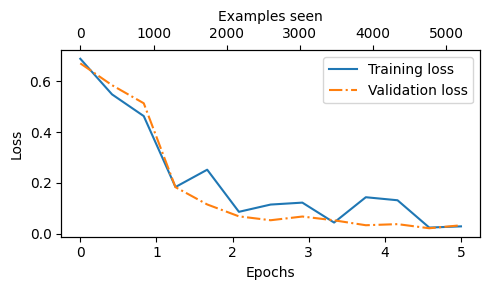

In [172]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

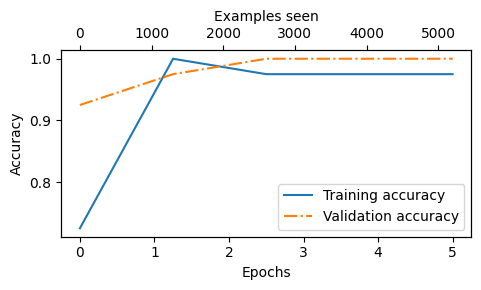

In [173]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [174]:
train_accuracy = calc_accuracy_loader(train_dataloader, gpt, device)
val_accuracy = calc_accuracy_loader(val_dataloader, gpt, device)
test_accuracy = calc_accuracy_loader(test_dataloader, gpt, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 99.36%
Test accuracy: 98.44%


In [ ]:
# Testing the model on real data:
txt = (
    "You are a winner you have been specially" 
    " selected to receive $2938 cash or a $2000 award."
)
encoding = torch.tensor([tokenizer.encode(txt)])
logits = gpt(encoding)
answer = torch.argmax(logits[:, -1, :], -1)
torch.
answer

tensor([0])